In [1]:
import os
import urllib.request
import zipfile
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Загрузка и распаковка датасета
def download_and_unzip(url, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    zip_path = os.path.join(dest_dir, "dataset.zip")

    if not os.path.exists(zip_path):
        print(f"Скачивание {url}...")
        urllib.request.urlretrieve(url, zip_path)
        print("Распаковка...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dest_dir)
        print("Готово!")
    else:
        print("Архив уже скачан.")

dataset_dir = "DUTS"
duts_train_url = "http://saliencydetection.net/duts/download/DUTS-TR.zip"
duts_test_url = "http://saliencydetection.net/duts/download/DUTS-TE.zip"

download_and_unzip(duts_train_url, dataset_dir)
download_and_unzip(duts_test_url, dataset_dir)

train_image_dir = os.path.join(dataset_dir, "DUTS-TR/DUTS-TR-Image")
train_mask_dir = os.path.join(dataset_dir, "DUTS-TR/DUTS-TR-Mask")

test_from_train = True

class DUTSDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))

        if not self.mask_paths:
            self.mask_paths = sorted(glob(os.path.join(mask_dir, "*.jpg")))

        if not self.mask_paths:
            print(f"[Ошибка] Не найдено масок в {mask_dir}")

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            mask = torch.where(mask > 0.5, torch.tensor(1.0), torch.tensor(0.0))

        return image, mask

# Трансформации
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


full_train_dataset = DUTSDataset(train_image_dir, train_mask_dir, transform=data_transforms)

# Сократим общий тренировочный набор (для ускорения обучения)
subset_size = int(0.2 * len(full_train_dataset))
train_dataset, _ = torch.utils.data.random_split(full_train_dataset, [subset_size, len(full_train_dataset) - subset_size])

train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])

# Даталоадеры
data_tr = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
data_val = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
data_ts = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Скачивание http://saliencydetection.net/duts/download/DUTS-TR.zip...
Распаковка...
Готово!
Архив уже скачан.
Train: 1688, Val: 211, Test: 211


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Функции потерь

1. **Двоичная кросс-энтропия** (Binary Cross Entropy) $-$ популярный лосс в задачах сегтменации. Главная проблема данной функции заключается в численной нестабильности. Поэтому используется эквивалентаная функция:

$$\mathcal{L}_{BCE}=\hat y_i-y_i\cdot\hat y_i+log(1+exp(-\hat y_i)).$$

2. **Dice coefficient** $-$ функция оценивающая меру близости между картами ответов и предсказаний. Является отношением верно угаданных пикселей к их общему числу. Оценка сверху данной функции задаётся следующей формулой:

$$\mathcal{L}_{D}=1- \frac{2\cdot\sum_iX_iY_i}{\sum_iX_i+Y_i}.$$

3. **Dice + BCE Loss** $-$ композиция двух лоссов.


In [3]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - torch.mul(y_pred, y_real) + torch.log(1 + torch.exp(-1 * y_pred)))

def dice_loss(y_real, y_pred):

    y_pred = y_pred.contiguous().view(-1)
    y_real = y_real.contiguous().view(-1)

    intersection = (y_pred * y_real).sum()
    A_sum = torch.sum(y_pred * y_pred)
    B_sum = torch.sum(y_real * y_real)
    return 1 - ((2. * intersection) / (A_sum + B_sum))

def dice_bce_loss(y_real, y_pred):
    dice = dice_loss(y_real, y_pred)
    bce = bce_loss(y_real, y_pred)
    return bce + dice

# Метрика качества

В качестве метрики качества была выбрана метрика **IoU**. Метрика иллюстрирует отношение верно угаданных пикселей к общему числу найденных пикселей класса:

$$I o U=\frac{\text {T} \cap \text {P}}{\text {T} \cup{P}}$$

In [4]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))

    iou = (intersection + SMOOTH) / (union + SMOOTH)

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10

    return thresholded

In [5]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)
            Y_pred = model(X_batch)
            Y_pred = (Y_pred >= 0.5).float()
            scores += metric(Y_pred, Y_label).mean().item()
    return scores / len(data)

# Архитектуры

Для обучения были выбраны две зарекомендовавшие себя в решении задач сегментации модели: **SegNet** и **UNet**. Главная отличительная особенность архитектур моделей, предназначенных для задач сегментации, наличие декодера. Задача декодера заключается в восстановлении изображения по информативному-векторному представлению исходной картинки.

**SegNet** состоит из энкодера и декодера. В данной реализации модель в части энкодера запоминает индексы maxpool'а и передаёт их в декодер.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        #ENCODER_LAYERS
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        #DECODER_LAYERS
        self.dec1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.dec3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.dec4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

    def forward(self, x):
        #ENCODER
        x = self.enc1(x)
        x, id1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        x = self.enc2(x)
        x, id2 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        x = self.enc3(x)
        x, id3 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        x = self.enc4(x)
        x, id4 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)

        #DECODER
        x = F.max_unpool2d(x, id4, kernel_size=2, stride=2)
        x = self.dec1(x)
        x = F.max_unpool2d(x, id3, kernel_size=2, stride=2)
        x = self.dec2(x)
        x = F.max_unpool2d(x, id2, kernel_size=2, stride=2)
        x = self.dec3(x)
        x = F.max_unpool2d(x, id1, kernel_size=2, stride=2)
        x = self.dec4(x)

        return x

**UNet v1**

Данная реализация UNet соддержит **maxpool** 2x2 co **stride**=1.

In [7]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True)
    )

class Unet(nn.Module):

    def __init__(self):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 1024)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up4 = double_conv(512 + 1024, 512)
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        conv5 = self.dconv_down5(x)

        x = torch.cat([x, conv5], dim=1)
        x = self.upsample(x)
        x = self.dconv_up4(x)


        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

**UNet v2**

Данная реализация UNet соддержит **maxpool** 2x2 co **stride**=1.

In [8]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True)
    )

class Unet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 1024)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dconv_up4 = double_conv(512 + 1024, 512)

        self.upsample3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv_up3 = double_conv(256 + 512, 256)

        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv_up2 = double_conv(128 + 256, 128)

        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv_last = nn.Conv2d(64, 1, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        conv5 = self.dconv_down5(x)
        x = self.maxpool(conv5)

        x = self.upsample4(x)
        x = torch.cat((x, conv5), dim=1)
        x = self.dconv_up4(x)

        x = self.upsample3(x)
        x = torch.cat((x, conv4), dim=1)
        x = self.dconv_up3(x)

        x = self.upsample2(x)
        x = torch.cat((x, conv3), dim=1)
        x = self.dconv_up2(x)

        x = self.upsample1(x)
        x = torch.cat((x, conv2), dim=1)
        x = self.dconv_up1(x)

        x = self.upsample0(x)
        out = self.conv_last(x)

        return out

# Функция train

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal


In [10]:
# Структура словаря: архитектура + loss: [train_history, test_history, iou_train, iou_test, pytorch_total_params]

models = {}

In [11]:
def visualization_history(train: list, test: list, epochs: int, loss_name: str, model_name: str):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train, label='train')
    plt.plot(range(1, epochs + 1), test, label='val')
    plt.title(f'Loss history of {model_name} with {loss_name}')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [12]:
def visualization_segmentation(X_val, Y_val, Y_hat, loss, epoch, epochs):
    for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')
            #REAL_SEGMENTATION
            plt.subplot(3, 6, k+7)
            plt.imshow(Y_val[k, 0].numpy(), cmap='gray')
            plt.title('Target')
            plt.axis('off')
            #PREDICT_SEGMENTATION
            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k, 0].detach().numpy(), cmap='gray')
            plt.title('Output')
            plt.axis('off')

    plt.suptitle(f'{epoch + 1}/{epochs} train_loss: {Decimal(loss.item()):.2E}')
    plt.show()

In [13]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):

    X_val, Y_val = next(iter(data_val))

    loss_history = []
    train_history = []
    test_history = []

    for epoch in range(epochs):
        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:

            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            Y_pred = model(X_batch)

            loss = loss_fn(Y_batch, Y_pred)

            loss.backward()
            opt.step()

            avg_loss += loss / len(data_tr)

        train_history.append(loss.cpu().item())

        model.eval()

        Y_hat = model(X_val.to(device))
        Y_hat = (Y_hat > 0.5).float()

        test_history.append(loss_fn(Y_val.to(device), Y_hat).cpu().item())

        if epoch + 1 in [1, 20, 40]:
          visualization_segmentation(X_val, Y_val, Y_hat.cpu(), avg_loss, epoch, epochs)

    return train_history, test_history

In [14]:
#code for clearing RAM
import gc

#del model
#del opt
torch.cuda.empty_cache()
gc.collect()

0

# Обучение (SegNet)



In [15]:
model = SegNet().to(device)
max_epochs = 40
opt = torch.optim.Adam(model.parameters())
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

15278595

**BCE loss**

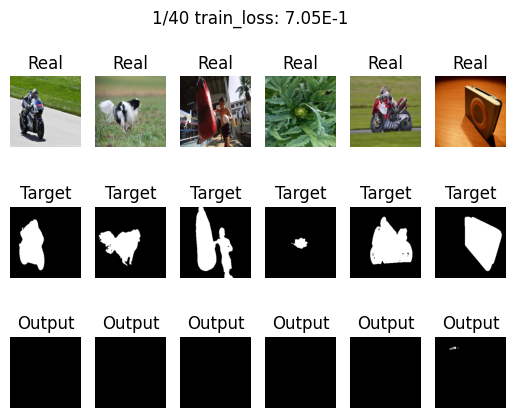

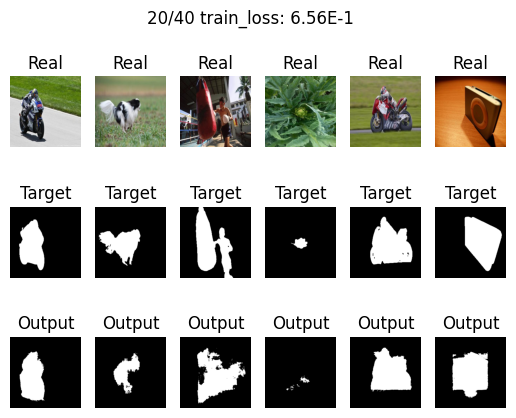

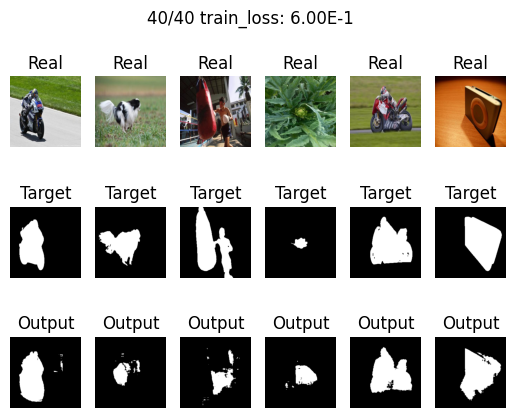

In [16]:
train_history, test_history = train(model, opt, bce_loss, max_epochs, data_tr, data_val)

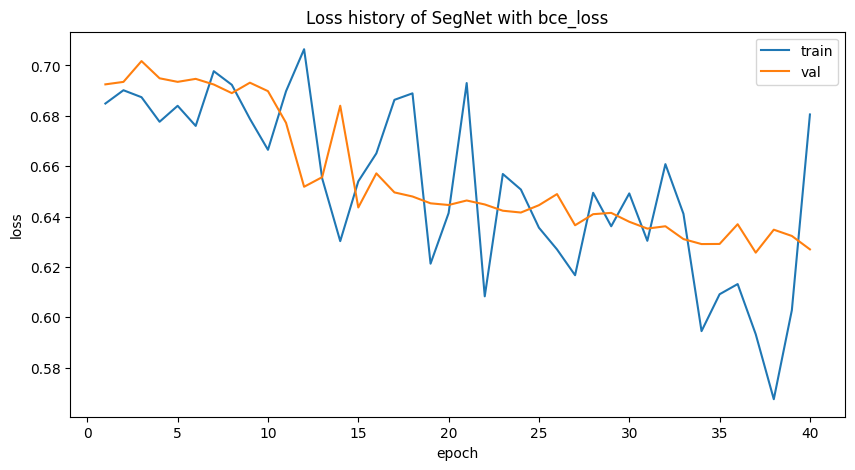

In [17]:
visualization_history(train_history, test_history, max_epochs, 'bce_loss', 'SegNet')
iou_train = score_model(model, iou_pytorch, data_tr)
iou_test = score_model(model, iou_pytorch, data_ts)
models['bce_loss' + 'SegNet'] = [train_history, test_history, iou_train, iou_test, pytorch_total_params]

**DICE loss**

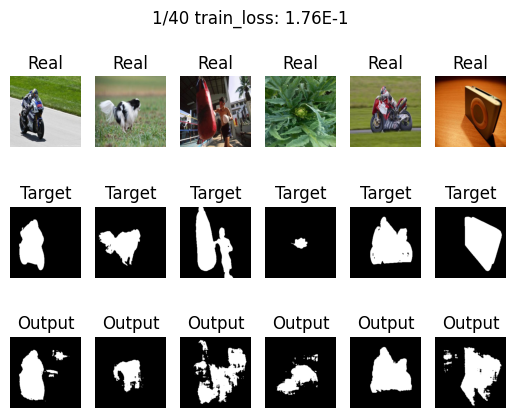

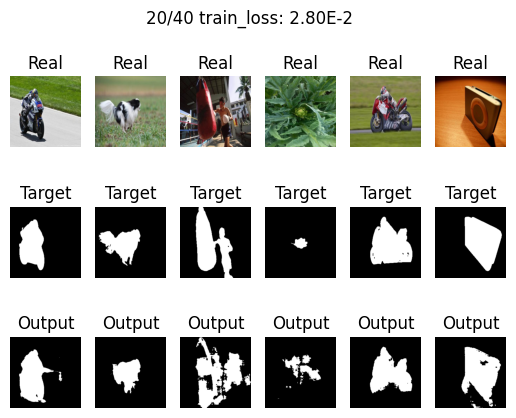

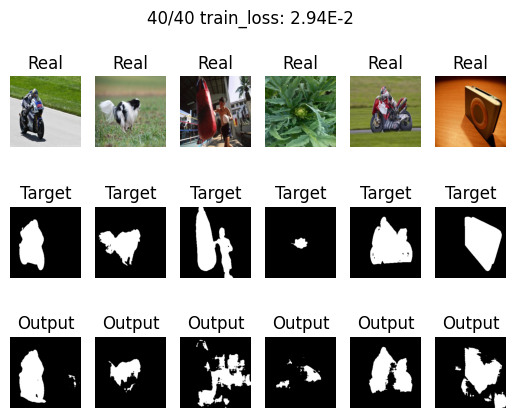

In [18]:
train_history, test_history = train(model, opt, dice_loss, max_epochs, data_tr, data_val)

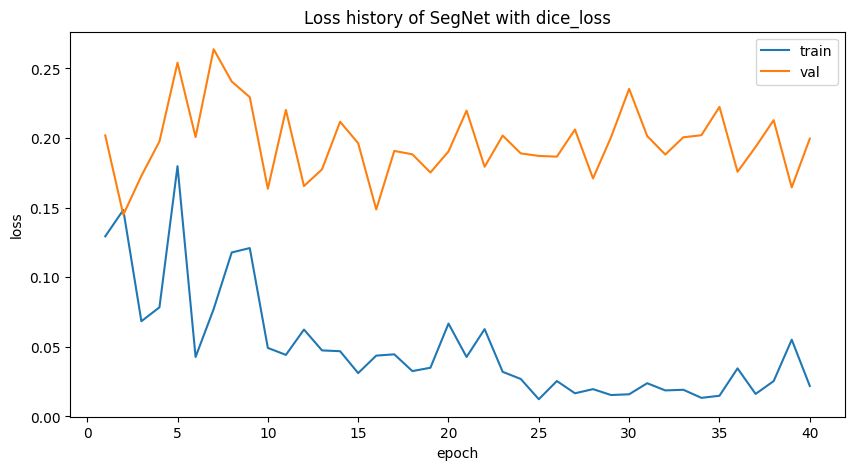

In [19]:
visualization_history(train_history, test_history, max_epochs, 'dice_loss', 'SegNet')
iou_train = score_model(model, iou_pytorch, data_tr)
iou_test = score_model(model, iou_pytorch, data_ts)
models['dice_loss' + 'SegNet'] = [train_history, test_history, iou_train, iou_test, pytorch_total_params]

**DICE + BCE Loss**

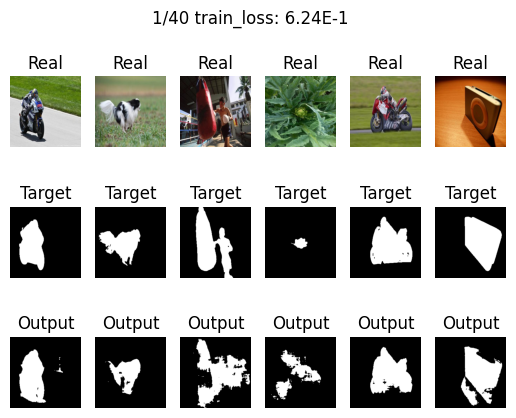

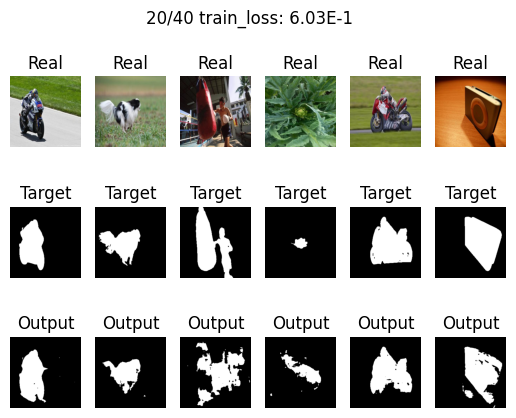

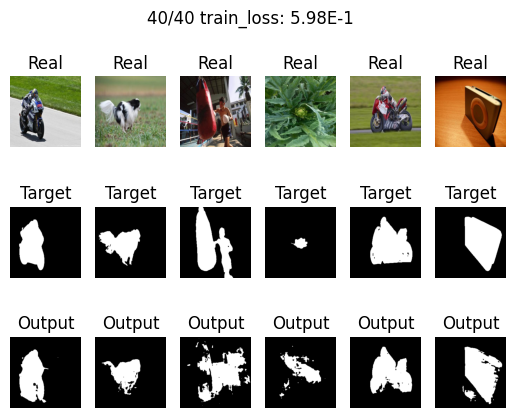

In [20]:
train_history, test_history = train(model, opt, dice_bce_loss, max_epochs, data_tr, data_val)

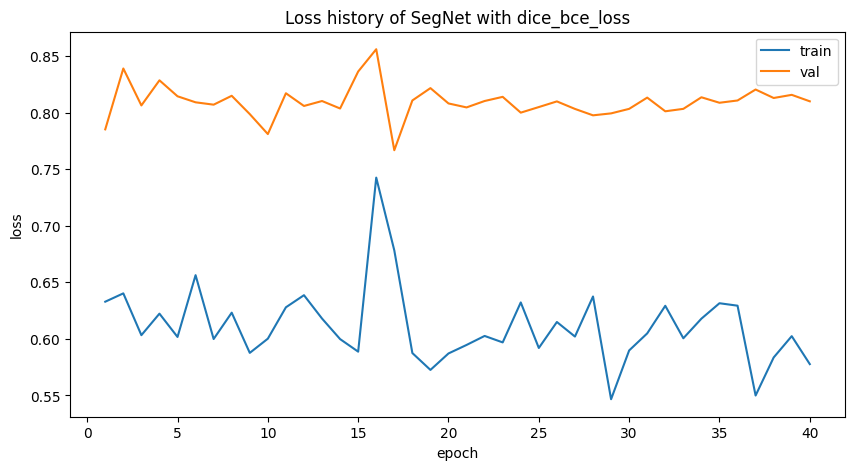

In [21]:
visualization_history(train_history, test_history, max_epochs, 'dice_bce_loss', 'SegNet')
iou_train = score_model(model, iou_pytorch, data_tr)
iou_test = score_model(model, iou_pytorch, data_ts)
models['dice_bce_loss' + 'SegNet'] = [train_history, test_history, iou_train, iou_test, pytorch_total_params]

# Обучение (UNet)

**UNet1**

In [22]:
model = Unet().to(device)
max_epochs = 40
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

31390721

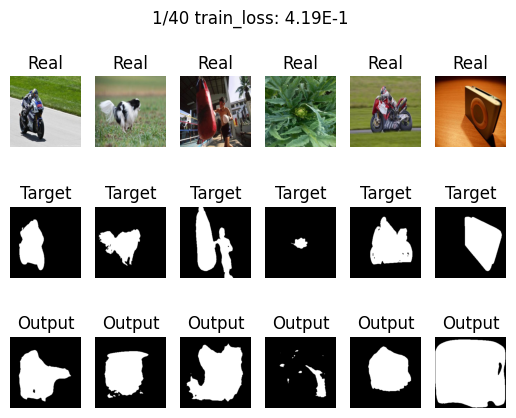

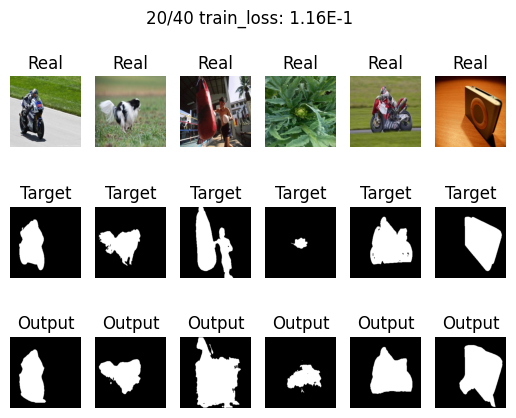

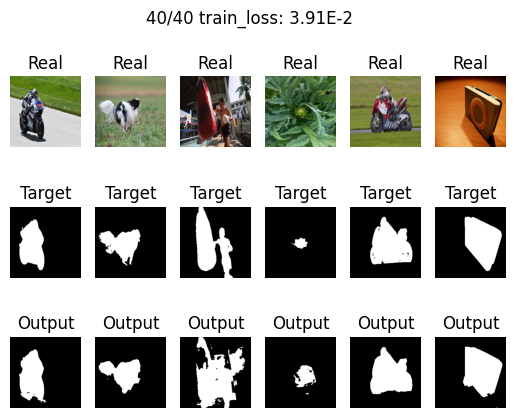

In [23]:
train_history, test_history = train(model, torch.optim.Adam(model.parameters()), dice_loss, max_epochs, data_tr, data_val)

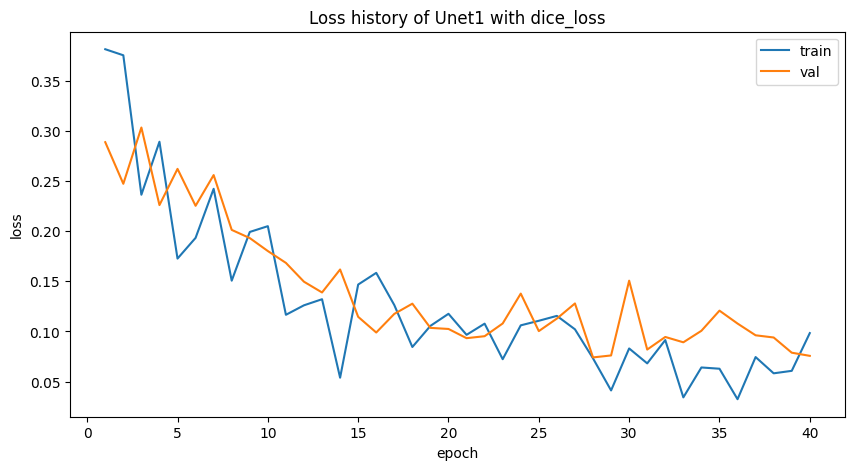

In [24]:
visualization_history(train_history, test_history, max_epochs, 'dice_loss', 'Unet1')
iou_train = score_model(model, iou_pytorch, data_tr)
iou_test = score_model(model, iou_pytorch, data_ts)
models['dice_loss' + 'Unet1'] = [train_history, test_history, iou_train, iou_test, pytorch_total_params]

**UNet2**

In [25]:
model = Unet2().to(device)
max_epochs = 40
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

34193409

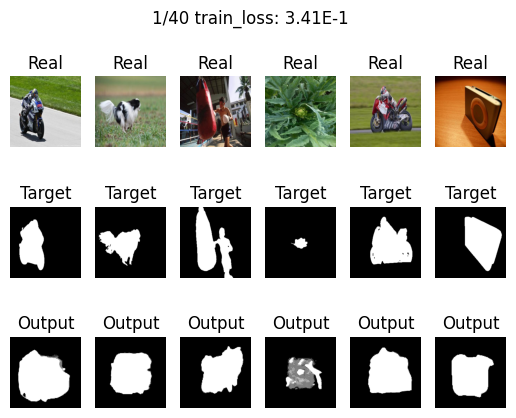

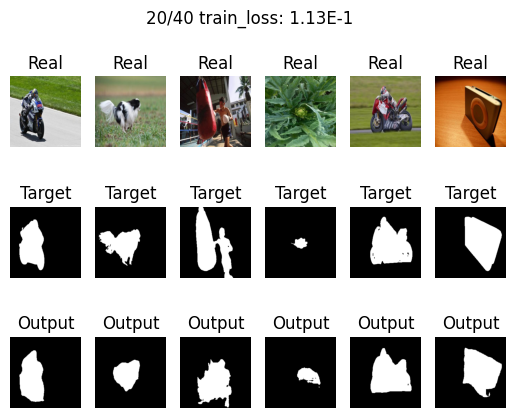

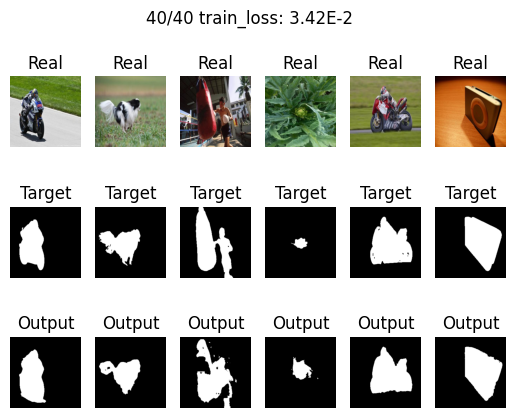

In [26]:
train_history, test_history = train(model, torch.optim.Adam(model.parameters()), dice_loss, max_epochs, data_tr, data_val)

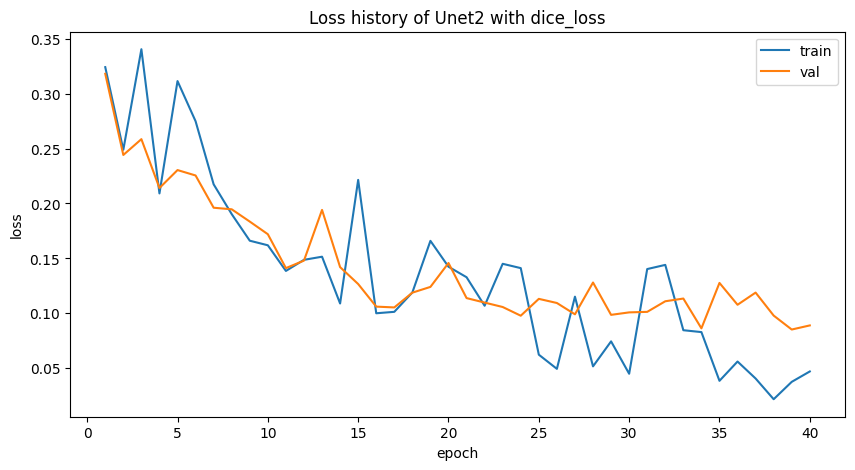

In [27]:
visualization_history(train_history, test_history, max_epochs, 'dice_loss', 'Unet2')
iou_train = score_model(model, iou_pytorch, data_tr)
iou_test = score_model(model, iou_pytorch, data_ts)
models['dice_loss' + 'Unet2'] = [train_history, test_history, iou_train, iou_test, pytorch_total_params]

#Анализ архитектур и лоссов
Данный раздел посвящен качественному сравнению обученных моделей. Основные критерии сравнения качества: метрика, поведение функции обучения в процессе и количество параметров. Для начала сравним количество параметров у Senget, Unet1, Unet2.


In [28]:
SegNet_param = models['dice_lossSegNet'][4]
UNet1_param = models['dice_lossUnet1'][4]
UNet2_param = models['dice_lossUnet2'][4]

min_param = min(SegNet_param, UNet1_param, UNet2_param)

SegNet_param / min_param, UNet1_param / min_param, UNet2_param / min_param

(1.0, 2.0545554745053454, 2.237994331285043)

Как видно UNet1 имеет в два раза больше параметров, чем SegNet. UNet2 в 2,24 раза больше чем SegNet.

Теперь поближе разберемся с SegNet и её лоссами. Визуализируем все на одном графике.

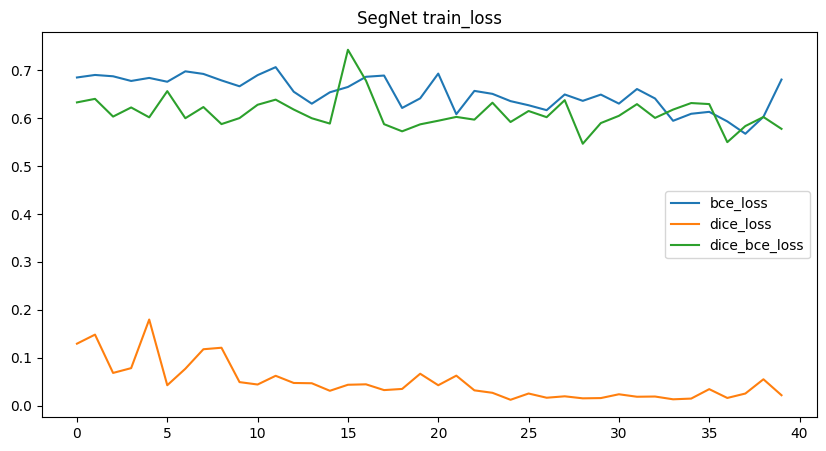

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(range(40), models['bce_lossSegNet'][0], label='bce_loss')
plt.plot(range(40), models['dice_lossSegNet'][0], label='dice_loss')
plt.plot(range(40), models['dice_bce_lossSegNet'][0], label='dice_bce_loss')
plt.legend()
plt.title('SegNet train_loss')
plt.show()

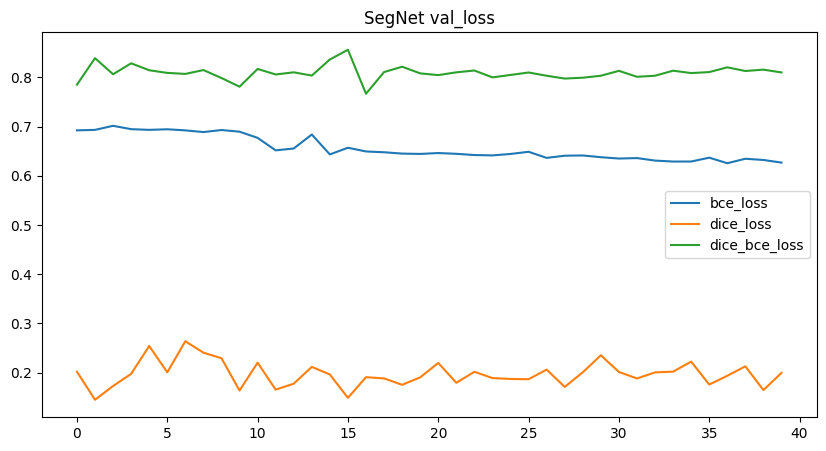

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(range(40), models['bce_lossSegNet'][1], label='bce_loss')
plt.plot(range(40), models['dice_lossSegNet'][1], label='dice_loss')
plt.plot(range(40), models['dice_bce_lossSegNet'][1], label='dice_bce_loss')
plt.legend()
plt.title('SegNet val_loss')
plt.show()

Как видно, модели плохо обучались, перепада с начальной инициализей не наблюдается.


Сравним метрики качества, дабы окончательно выдать приз лучшему лоссу.


In [31]:
import pandas as pd

data = []
for item in models:
    if item != 'dice_lossUnet1' and item != 'dice_lossUnet2':
        data.append([item, models[item][2], models[item][3]])

col = ['loss', 'iou_train', 'iou_test']

df = pd.DataFrame(data, columns=col)
df

,loss,iou_train,iou_test
0,bce_lossSegNet,0.444634,0.289137
1,dice_lossSegNet,0.908962,0.366518
2,dice_bce_lossSegNet,0.994163,0.398214


Видно, что лучше всего себя показала себя комбинированная  dice_bce_loss.


Теперь сравним архитектуры UNet1 и UNet2. Во время обучения на валидационной выборе на мой взгляд вообще над всеми архитектурами лидировал UNet2. Посмотрим так ли это.

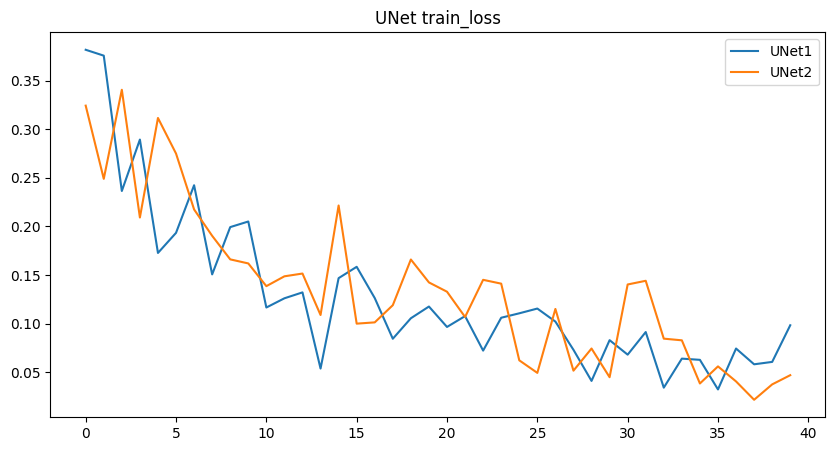

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(range(40), models['dice_lossUnet1'][0], label='UNet1')
plt.plot(range(40), models['dice_lossUnet2'][0], label='UNet2')
plt.legend()
plt.title('UNet train_loss')
plt.show()

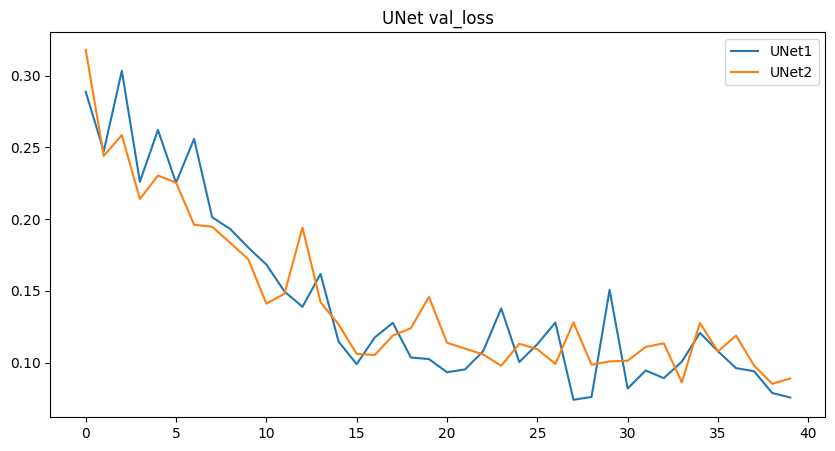

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(range(40), models['dice_lossUnet1'][1], label='UNet1')
plt.plot(range(40), models['dice_lossUnet2'][1], label='UNet2')
plt.legend()
plt.title('UNet val_loss')
plt.show()

Почти одинакаво, на на плато быстрее выходит UNet2.
В целом обе модели хорошо обучались, виден большой спад с начальной инициализацией. Но всё, конечно, не так идеально.

Сравним теперь все архитетуры и их метрики.



In [34]:
import pandas as pd

data = []
for item in models:
    data.append([item, models[item][2], models[item][3]])

col = ['Architecture', 'iou_train', 'iou_test']

df = pd.DataFrame(data, columns=col)
df

,Architecture,iou_train,iou_test
0,bce_lossSegNet,0.444634,0.289137
1,dice_lossSegNet,0.908962,0.366518
2,dice_bce_lossSegNet,0.994163,0.398214
3,dice_lossUnet1,0.840625,0.552679
4,dice_lossUnet2,0.870224,0.510268


UNet1 вырвался в лидеры с dice_loss.